# Homework 2 (regressão)

**GRUPO:**

- Gabriel Vasconcelos Fruet - 537618
- Kelvin Leandro Martins - 540006
- Mateus Pereira Santos - 541048
- Pedro Leinos Falcão Cunha - 542114

## Dados

## Bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from train import kfold_training, evaluate_model
from preprocessing import preprocess

from functools import partial

## Leitura dos dados

In [ ]:
from loading import load_data

(solTrainX, solTrainXtrans, solTrainY), \
(solTestX, solTestXtrans, solTestY) = load_data()

# Utilitárias

In [ ]:
import matplotlib.patches as mpatches

def plot_model_accuracy(result, test_result, fname):
  LABEL_SIZE = 15
  fig, ax = plt.subplots(2,1, figsize=(6,8))
  twinax = [axis.twinx() for axis in ax]
  five_folds = result[result['Number of Folds'] == 5], test_result[test_result['Folds'] == 5]
  ten_folds = result[result['Number of Folds'] == 10], test_result[test_result['Folds'] == 10]

  for i, data in enumerate([five_folds, ten_folds]):
    train, test = data
    n_folds = len(train)
    folds = np.arange(n_folds)

    ax[i].plot(train['RMSE'], color='tab:blue')
    ax[i].plot(folds, np.repeat(test['RMSE'], n_folds), color='gray',  linestyle='dashed')

    ax[i].set_ylabel('RMSE', fontsize=LABEL_SIZE)
    ax[i].set_xlabel('Fold', fontsize=LABEL_SIZE)
    ax[i].set_xticks(folds)
    ax[i].set_ylim(train['RMSE'].min() * 0.7, train['RMSE'].max() * 1.3)

    twinax[i].plot(train['R^2'], color='red')
    twinax[i].plot(folds, np.repeat(test['R^2'], n_folds), color='black',  linestyle='dashed')
    twinax[i].set_ylim(train['R^2'].min() * 0.7, train['R^2'].max() * 1.3)
    twinax[i].set_ylabel('R^2', fontsize=LABEL_SIZE)

  handles = [
      mpatches.Patch(color='tab:blue', label='Train RMSE'),
      mpatches.Patch(color='red', label='Train R^2'),
      mpatches.Patch(color='gray', label='Test RMSE'),
      mpatches.Patch(color='black', label='Test R^2'),
  ]

  fig.legend(handles=handles, loc='upper center')
  fig.savefig(fname, dpi=300, transparent=True)
  fig.show()

## Pré-processamento

## Modelos

### Ordinary Least Square (OLS)

- 5 or 10 fold cross validation
- use rmse and r²

#### Custom

In [ ]:
from regressors import least_squares

def fit_transform_ols(X_train, y_train, X_val):
    b,_ = least_squares(X_train, y_train)
    return X_val @ b, b

def predict_ols(X, coefs):
    return X @ coefs

print('OLS custom:')
ols_result_custom = None
ols_test_result_custom = None
ols_scaler_path = './scalers/ols_scaler.gz'
solTrainX_preprocessed = preprocess(solTrainX, save_path=ols_scaler_path, add_intercept=True)
solTestX_preprocessed = preprocess(solTestX, load_path=ols_scaler_path, add_intercept=True)
for n_folds in [5,10]:
    print(f'OLS {n_folds} folds')
    result, b = kfold_training(
        solTrainX_preprocessed,
        np.array(solTrainY),
        fit_transform_ols,
        n_folds=n_folds
    )

    ols_result_custom = pd.concat([ols_result_custom, result])

    r2, rmse = evaluate_model(solTestX_preprocessed, solTestY, partial(predict_ols, coefs=b))
    ols_test_result_custom = pd.concat([
          ols_test_result_custom,
          pd.DataFrame({ \
              'R^2': [r2],
              'RMSE': [rmse],
              'Folds': n_folds
              })
          ])

OLS custom:
OLS 5 folds
Test R^2: 0.8601353137530225
Test RMSE: 0.7760862285716713
OLS 10 folds
Test R^2: 0.8782273606743646
Test RMSE: 0.7241537748813835


In [ ]:
ols_test_result_custom

,R^2,RMSE,Folds
0,0.860135,0.776086,5
0,0.878227,0.724154,10


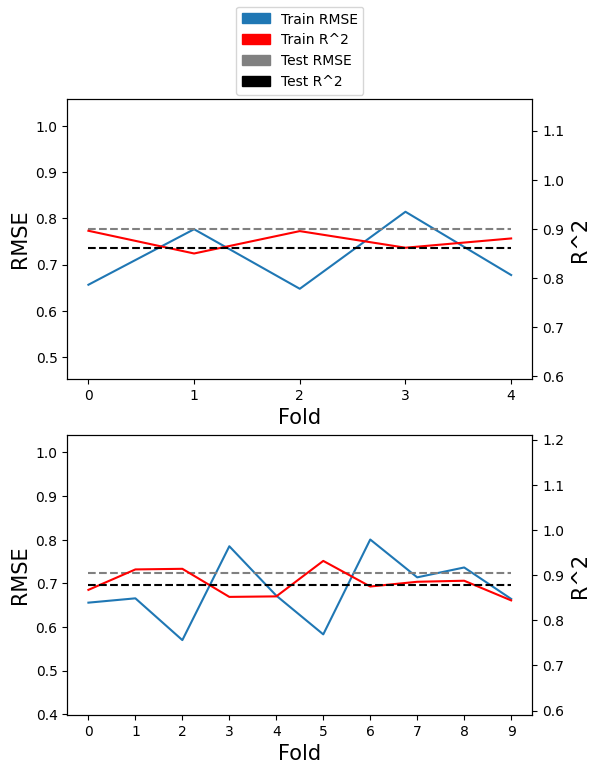

In [ ]:
plot_model_accuracy(ols_result_custom, ols_test_result_custom, "./images/ols_accuracy_custom.png")

#### NumPy

In [ ]:
def fit_transform_ols(X_train, y_train, X_val):
    b = np.linalg.lstsq(X_train, y_train, rcond=None)[0]
    return predict_ols(X_val, b), b

def predict_ols(X, coefs):
    return X @ coefs

print('OLS sklearn:')
ols_test_result_numpy = None
ols_result_numpy = None
ols_scaler_path = './scalers/ols_scaler.gz'
solTrainX_preprocessed = preprocess(solTrainX, save_path=ols_scaler_path, add_intercept=True)
solTestX_preprocessed = preprocess(solTestX, load_path=ols_scaler_path, add_intercept=True)
for n_folds in [5,10]:
    print(f'OLS {n_folds} folds')
    result, b = kfold_training(
        solTrainX_preprocessed,
        np.array(solTrainY),
        fit_transform_ols,
        n_folds=n_folds
    )

    ols_result_numpy = pd.concat([ols_result_numpy, result])
    r2, rmse = evaluate_model(solTestX_preprocessed, solTestY, partial(predict_ols, coefs=b))
    ols_test_result_numpy = pd.concat([
        ols_test_result_numpy,
        pd.DataFrame({ \
            'R^2': [r2],
            'RMSE': [rmse],
            'Folds': n_folds
        })
    ])

OLS sklearn:
OLS 5 folds
Test R^2: 0.8601353137530225
Test RMSE: 0.7760862285716715
OLS 10 folds
Test R^2: 0.8782273606743647
Test RMSE: 0.7241537748813832


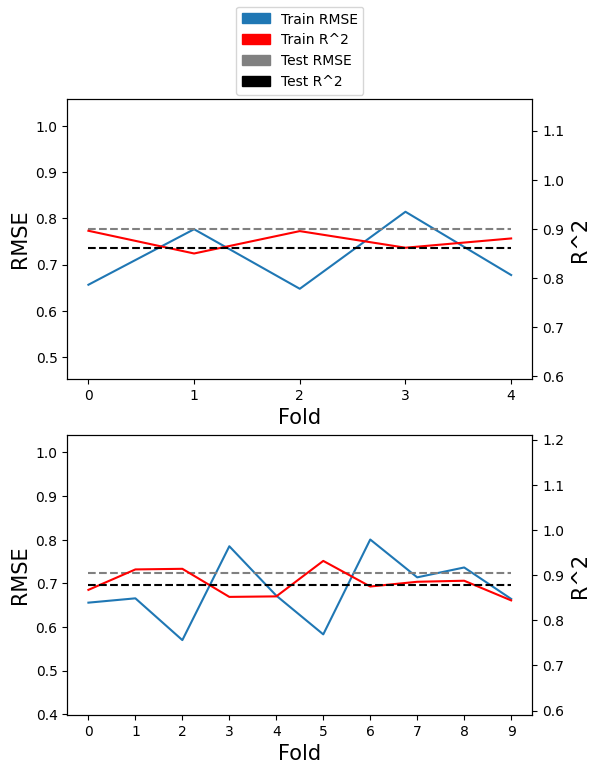

In [ ]:
plot_model_accuracy(ols_result_numpy,ols_test_result_numpy, "./images/ols_accuracy_sklearn.png")

### L2 (ou L1)-penalised linear regression

- determine optimal value of $\lambda$
- use a 5 or 10 fold cross validation based on RMSE
- RMSE and R²


#### Custom

In [ ]:
%%capture
from regressors import ridge_regressor

predict_ridge = predict_ols

def fit_transform_ridge(X_train, y_train, X_val, penalty):
    b,_ = ridge_regressor(X_train, y_train, penalty)
    return X_val @ b, b

print('Ridge:')

ridge_test_result = None
ridge_result = None

START = 0.1
END = 20
penalties = np.exp(np.linspace(np.log(START), np.log(END), 30))

ridge_scaler_path = './scalers/ridge_scaler.gz'
solTrainX_preprocessed = preprocess(solTrainX, save_path=ridge_scaler_path, add_intercept=True)
solTestX_preprocessed = preprocess(solTestX, load_path=ridge_scaler_path, add_intercept=True)
for p in penalties:
    for n_folds in [5,10]:
        print(f'Ridge with {n_folds} folds and penalty {p=}')
        result, params = kfold_training(
            solTrainX_preprocessed,
            np.array(solTrainY),
            partial(fit_transform_ridge, penalty=p),
            n_folds=n_folds)

        result['lambda'] = p
        ridge_result = pd.concat([ridge_result, result])

        r2, rmse = evaluate_model(solTestX_preprocessed, solTestY, partial(predict_ridge, coefs=params))
        ridge_test_result = pd.concat([
          ridge_test_result,
          pd.DataFrame({ \
              'R^2': [r2],
              'RMSE': [rmse],
              'Folds': n_folds,
              'lambda': p
          })
        ])

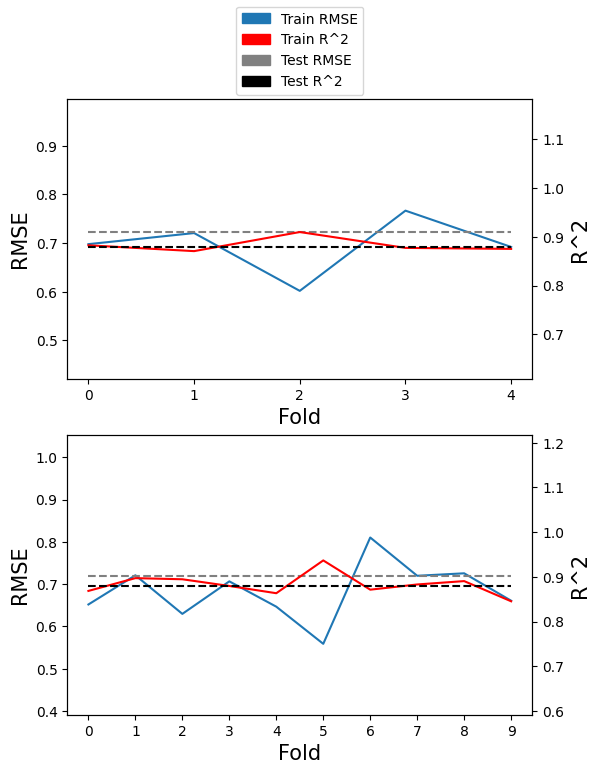

In [ ]:
best_ridge_result = ridge_result[np.isclose(ridge_result['lambda'], 13.87, atol=1)]
best_ridge_test_result = ridge_test_result[np.isclose(ridge_test_result['lambda'], 13.87, atol=1)]
plot_model_accuracy(best_ridge_result, best_ridge_test_result, "./images/ridge_accuracy_custom.png")

In [ ]:
best_ridge_test_result

,R^2,RMSE,Folds,lambda
0,0.878476,0.723414,5,13.878364
0,0.879844,0.719330,10,13.878364


In [ ]:
best_ridge_result

,RMSE,R^2,Number of Folds,lambda
0,0.697859,0.882478,5.0,13.878364
1,0.720628,0.870573,5.0,13.878364
2,0.601842,0.909635,5.0,13.878364
3,0.766708,0.877174,5.0,13.878364
4,0.692095,0.875163,5.0,13.878364
0,0.652060,0.868669,10.0,13.878364
1,0.721082,0.897241,10.0,13.878364
2,0.629804,0.894722,10.0,13.878364
3,0.706732,0.879741,10.0,13.878364
4,0.646826,0.863517,10.0,13.878364


In [ ]:
ridge_result

,RMSE,R^2,Number of Folds,lambda
0,0.659437,0.895062,5.0,0.1
1,0.782450,0.847414,5.0,0.1
2,0.648307,0.895143,5.0,0.1
3,0.809642,0.863033,5.0,0.1
4,0.682392,0.878639,5.0,0.1
...,...,...,...,...
5,0.559765,0.936681,10.0,20.0
6,0.804695,0.873281,10.0,20.0
7,0.721403,0.882614,10.0,20.0
8,0.729062,0.889621,10.0,20.0


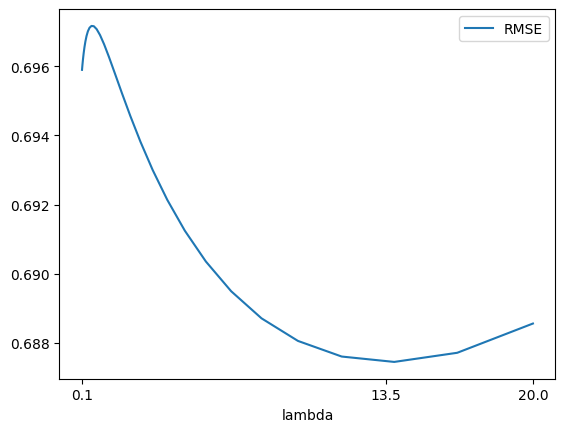

In [ ]:
ax = ridge_result.groupby('lambda').mean().plot(y='RMSE', kind='line', )#title='RMSE vs lambda')
ax.set_xticks([START, 13.5, END])

plt.savefig("./images/penalty_vs_rmse_custom.png", dpi=300, transparent=True)
plt.show()

#### Sklearn

In [ ]:
%%capture
from sklearn.linear_model import Ridge

def predict_ridge(X, coefs):
    return coefs.predict(X)

def fit_transform_ridge(X_train, y_train, X_val, penalty):
    r = Ridge(alpha=penalty, fit_intercept=True, copy_X=True, solver='lsqr')
    r.fit(X_train, y_train)
    return r.predict(X_val), r


print('Ridge')
ridge_test_result_sklearn = pd.DataFrame()
ridge_result_sklearn = pd.DataFrame()
START = 0.1
END = 40
penalties = np.exp(np.linspace(np.log(START), np.log(END), 30))

ridge_scaler_path = './scalers/ridge_scaler.gz'
solTrainX_preprocessed = preprocess(solTrainX, save_path=ridge_scaler_path, add_intercept=True)
solTestX_preprocessed = preprocess(solTestX, load_path=ridge_scaler_path, add_intercept=True)
for p in penalties:
    for n_folds in [5,10]:
        print(f'Ridge with {n_folds} folds and penalty {p=}')
        result, params = kfold_training(
            solTrainX_preprocessed,
            np.array(solTrainY),
            partial(fit_transform_ridge, penalty=p),
            n_folds=n_folds, kfold_method='sklearn')

        result['lambda'] = p
        ridge_result_sklearn = pd.concat([ridge_result_sklearn, result])

        r2, rmse = evaluate_model(solTestX_preprocessed, solTestY, partial(predict_ridge, coefs=params), add_intercept=True)
        ridge_test_result_sklearn = pd.concat([
          ridge_test_result_sklearn,
          pd.DataFrame({ \
              'R^2': [r2],
              'RMSE': [rmse],
              'Folds': n_folds,
              'lambda': p
          })
        ])

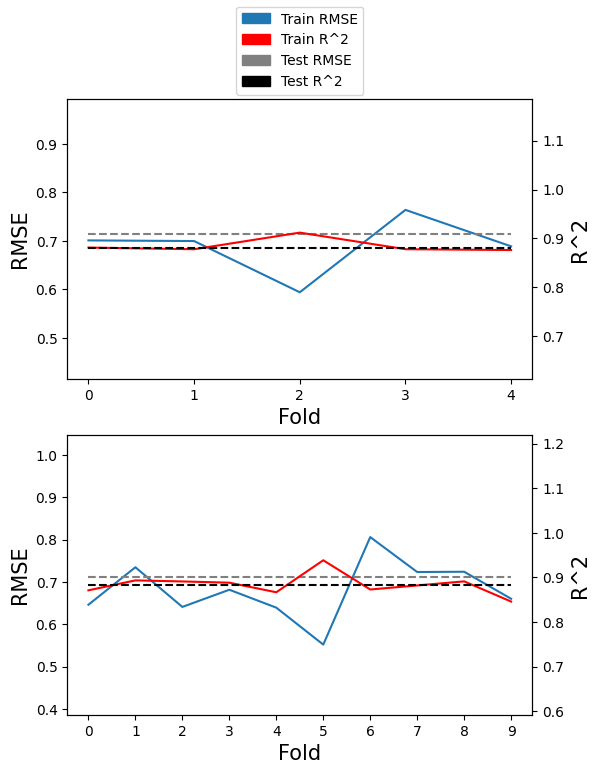

In [ ]:
best_ridge_result_sklearn = ridge_result_sklearn[np.isclose(ridge_result_sklearn['lambda'], 27, atol=1)]
best_ridge_test_result_sklearn = ridge_test_result_sklearn[np.isclose(ridge_test_result_sklearn['lambda'], 27, atol=1)]
plot_model_accuracy(best_ridge_result_sklearn, best_ridge_test_result_sklearn, "./images/ridge_accuracy_custom.png")

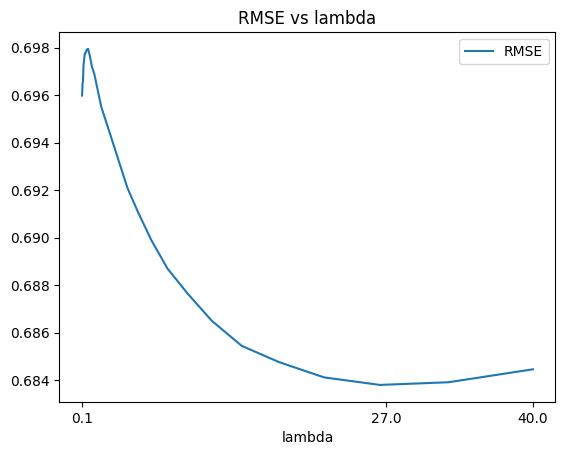

<Figure size 640x480 with 0 Axes>

In [ ]:
ax = ridge_result_sklearn.groupby('lambda').mean().plot(y='RMSE', kind='line', title='RMSE vs lambda')
ax.set_xticks([START, 27, END])

plt.show()
plt.savefig("./images/penalty_vs_rmse_sklearn.png", dpi=300, transparent=True)

### PLS ou PCR

- determine optimal number of components using 5 or 10 fold cross validationn based on RMSE
- RMSE and R²

In [ ]:
solTrainX.shape

(951, 228)

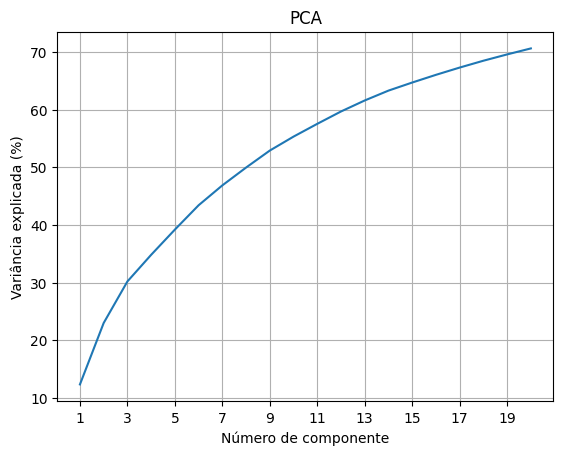

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(solTrainX.shape[1])
pca.fit(preprocess(solTrainX))

fig, ax = plt.subplots()
y = np.cumsum(pca.explained_variance_ratio_[:20]*100)
ax.plot(1 + np.arange(len(y), dtype=np.int32), y)
ax.set_xticks(np.arange(1, len(y) + 1, 2))
ax.set_xlabel('Número de componente')
ax.set_ylabel('Variância explicada (%)')
ax.set_title('PCA')
ax.grid()
fig.show()
fig.savefig('./images/var_explicada.png', dpi=300, transparent=True)

In [ ]:
def fit_transform_pls(X_train, y_train, X_val, n_components):
    pls = PLSRegression(n_components)
    pls.fit(X_train, y_train)
    return pls.predict(X_val), pls

def predict_pls(X, coefs):
    return coefs.predict(X)


pls_order = 4
print(f'PLS({pls_order}):')
pls_test_result = None
pls_result = None
pls_scaler_path = './scalers/pls_scaler.gz'
solTrainX_preprocessed = preprocess(solTrainX, save_path=pls_scaler_path)
solTestX_preprocessed = preprocess(solTestX, load_path=pls_scaler_path)
for n_folds in [5,10]:
    print(f'PLS({pls_order}) with {n_folds} folds')
    result, params = kfold_training(solTrainX_preprocessed,
                                np.array(solTrainY),
                                partial(fit_transform_pls, n_components=pls_order),
                                n_folds=n_folds)

    pls_result = pd.concat([pls_result, result])
    r2, rmse = evaluate_model(solTestX_preprocessed, solTestY, partial(predict_pls, coefs=params))
    pls_test_result = pd.concat([
        pls_test_result,
        pd.DataFrame({ \
            'R^2': [r2],
            'RMSE': [rmse],
            'Folds': n_folds,
        })
    ])


PLS(4):
PLS(4) with 5 folds
Test R^2: 0.8189605063560924
Test RMSE: 0.8829631979348677
PLS(4) with 10 folds
Test R^2: 0.8301452217001821
Test RMSE: 0.8552534283436617


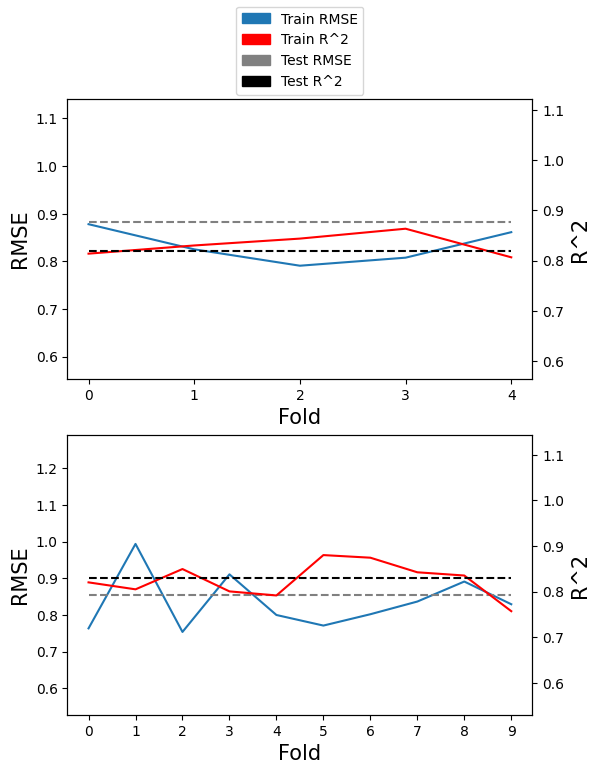

In [ ]:
plot_model_accuracy(pls_result, pls_test_result, "./images/pls_accuracy.png")

### Redes neurais

- RMSE and R²

In [ ]:
import keras
import tensorflow as tf

EPOCHS = 20
BATCH_SIZE = 16

def create_model():
  input = keras.layers.Input(shape=(solTrainX.shape[1],))
  x = keras.layers.Dense(128, activation='relu')(input)
  x = keras.layers.Dropout(0.2)(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal')(x)
  x = keras.layers.Dense(1, activation='linear')(x)
  return keras.models.Model(inputs=input, outputs=x)

def fit_transform_nn(X_train, y_train, X_val):
    model = create_model()
    print('-'*20)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.007), loss=keras.losses.MeanSquaredError(), metrics=[keras.metrics.MeanSquaredError(), keras.metrics.R2Score()])
    batched_data = batch_data(X_train, y_train, batch_size=BATCH_SIZE)
    model.fit(batched_data, batch_size=BATCH_SIZE, epochs=EPOCHS, steps_per_epoch=int(np.ceil(X_train.shape[0] / BATCH_SIZE)))
    return model(X_val), model

def predict_nn(X, coefs):
    return np.array(coefs(X))

def batch_data(features, labels, batch_size):
    num_batches = int(np.ceil(features.shape[0] / batch_size))
    while True:
      for i in range(num_batches):
          start_idx = i * batch_size
          end_idx = min((i + 1) * batch_size, features.shape[0])
          yield features[start_idx:end_idx], labels[start_idx:end_idx]


print(f'Neural Network:')
nn_result = None
nn_test_result = None
nn_scaler_path = './scalers/nn_scaler.gz'
solTrainX_preprocessed = preprocess(solTrainX, save_path=nn_scaler_path)
solTestX_preprocessed = preprocess(solTestX, load_path=nn_scaler_path)
with tf.device('/cpu:0'):
  for n_folds in [5,10]:
      print(f'Neural Newtork with {n_folds} folds')
      result, params = kfold_training(solTrainX_preprocessed,
                                  np.array(solTrainY),
                                  fit_transform_nn,
                                  n_folds=n_folds)

      nn_result = pd.concat([nn_result, result])
      r2, rmse = evaluate_model(solTestX_preprocessed, solTestY, partial(predict_nn, coefs=params))
      nn_test_result = pd.concat([
          nn_test_result,
          pd.DataFrame({ \
              'R^2': [r2],
              'RMSE': [rmse],
              'Folds': n_folds,
          })
      ])


Neural Network:
Neural Newtork with 5 folds
--------------------
Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 6.5471 - mean_squared_error: 6.5471 - r2_score: -0.6963
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1205 - mean_squared_error: 1.1205 - r2_score: 0.7191
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9083 - mean_squared_error: 0.9083 - r2_score: 0.7724
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6925 - mean_squared_error: 0.6925 - r2_score: 0.8275
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6084 - mean_squared_error: 0.6084 - r2_score: 0.8481
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5636 - mean_squared_error: 0.5636 - r2_score: 0.8584
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4299 - mean_squared_error: 0.4299 - r2_score: 0.8928
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4589 - mean_squared_error: 0.4589 - r2_score: 0.8852
Epoch 9/20
48/48 ━━━━━━━━━━━━━

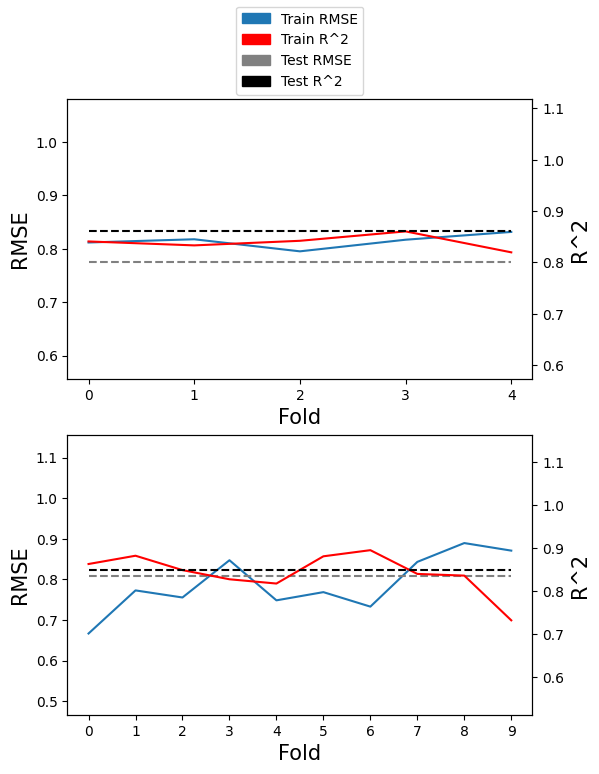

In [ ]:
plot_model_accuracy(nn_result, nn_test_result, "./images/nn_accuracy.png")

In [ ]:
nn_test_result

,R^2,RMSE,Folds
0,0.860440,0.775240,5
0,0.848314,0.808217,10
